<a href="https://colab.research.google.com/github/JoDeMiro/DeepLearningIntroduction/blob/main/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[//]: # (Image References)

[image1]: ./images/dog_localization.png "Dog Localization"

# ResNetCAM-keras
Keras implementation of a ResNet-CAM model

## Motivation

The original Matlab implementation and paper (for AlexNet, GoogLeNet, and VGG16) can be found [here](https://github.com/metalbubble/CAM).  A Keras implementation of VGG-CAM can be found [here](https://github.com/tdeboissiere/VGG16CAM-keras/blob/master/README.md).

This implementation is written in Keras and uses ResNet-50, which was __not__ explored in the original paper.  

## Requirements

- keras with tensorflow backend (keras version 2.0.0 or later)
- numpy
- ast
- scipy
- matplotlib
- opencv3

## Blog Post

This repository is discussed in the blog post [here](https://alexisbcook.github.io/2017/global-average-pooling-layers-for-object-localization/).


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
import numpy as np

In [ ]:
import numpy as np
import ast
import scipy
import matplotlib.pyplot as plt
import cv2
import sys

In [ ]:
def pretrained_path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))

    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)

    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    x = np.expand_dims(x, axis=0)
    
    # convert RGB -> BGR, subtract mean ImageNet pixel, and return 4D tensor
    return preprocess_input(x)


In [ ]:
def get_ResNet():
    # define ResNet50 model
    model = ResNet50(weights='imagenet')

    # get AMP layer weights
    all_amp_layer_weights = model.layers[-1].get_weights()[0]

    # extract wanted output
    ResNet_model = Model(inputs=model.input, 
        outputs=(model.layers[-4].output, model.layers[-1].output))
    
    return ResNet_model, all_amp_layer_weights

In [ ]:
def ResNet_CAM(img_path, model, all_amp_layer_weights):
    # get filtered images from convolutional output + model prediction vector
    last_conv_output, pred_vec = model.predict(pretrained_path_to_tensor(img_path))

    # change dimensions of last convolutional outpu tto 7 x 7 x 2048
    last_conv_output = np.squeeze(last_conv_output)

    # get model's prediction (number between 0 and 999, inclusive)
    pred = np.argmax(pred_vec)

    # bilinear upsampling to resize each filtered image to size of original image 
    mat_for_mult = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order=1) # dim: 224 x 224 x 2048

    # get AMP layer weights
    amp_layer_weights = all_amp_layer_weights[:, pred] # dim: (2048,)

    # get class activation map for object class that is predicted to be in the image
    final_output = np.dot(mat_for_mult.reshape((224*224, 2048)), amp_layer_weights).reshape(224,224) # dim: 224 x 224
    
    # return class activation map
    return final_output, pred

In [ ]:
def plot_ResNet_CAM(img_path, ax, model, all_amp_layer_weights):
    # load image, convert BGR --> RGB, resize image to 224 x 224,
    im = cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (224, 224))

    # plot image
    ax.imshow(im, alpha=0.5)

    # get class activation map
    CAM, pred = ResNet_CAM(img_path, model, all_amp_layer_weights)

    # plot class activation map
    ax.imshow(CAM, cmap='jet', alpha=0.5)

    # load the dictionary that identifies each ImageNet category to an index in the prediction vector
    with open('imagenet1000_clsid_to_human.txt') as imagenet_classes_file:
        imagenet_classes_dict = ast.literal_eval(imagenet_classes_file.read())
        
    # obtain the predicted ImageNet category
    ax.set_title(imagenet_classes_dict[pred])    

In [ ]:
%%capture
!rm *.png
!wget https://github.com/JoDeMiro/Data/raw/main/Images/woman1.png
!wget https://github.com/JoDeMiro/Data/raw/main/Images/woman2.png

rm: cannot remove '*.png': No such file or directory
--2022-04-05 12:17:53--  https://github.com/JoDeMiro/Data/raw/main/Images/woman1.png
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JoDeMiro/Data/main/Images/woman1.png [following]
--2022-04-05 12:17:54--  https://raw.githubusercontent.com/JoDeMiro/Data/main/Images/woman1.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 164047 (160K) [image/png]
Saving to: ‘woman1.png’

woman1.png          100%[===================>] 160.20K  --.-KB/s    in 0.01s   

2022-04-05 12:17:54 (11.6 MB/s) - ‘woman1.png’ saved [164047/164047]

--2022-04-05 12:17:54

In [ ]:
ResNet_model, all_amp_layer_weights = get_ResNet()

In [ ]:
img_path = 'woman1.png'

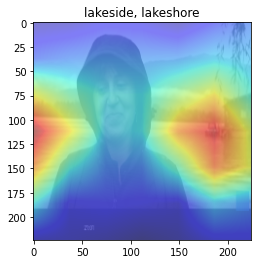

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
CAM = plot_ResNet_CAM(img_path, ax, ResNet_model, all_amp_layer_weights)
plt.show()